# Importing the Necessary Libraries and Dependencies

In [1]:
import pandas as pd
import numpy as np
from scipy import signal, integrate
import matplotlib.pyplot as plt
import logging
import os
from datetime import datetime
from scipy.fft import fft, fftfreq

# Statistical Analysis of Sesimic Data

2024-11-17 19:49:45,769 - SeismicAnalyzer - INFO - Successfully read CSV file
2024-11-17 19:49:45,769 - SeismicAnalyzer - INFO - Successfully read CSV file
INFO:SeismicAnalyzer:Successfully read CSV file
<ipython-input-5-151d28008d26>:61: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  vel = integrate.cumtrapz(acc, dx=dt, initial=0)
<ipython-input-5-151d28008d26>:62: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  disp = integrate.cumtrapz(vel, dx=dt, initial=0)
<ipython-input-5-151d28008d26>:69: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  cav = integrate.trapz(np.abs(acc), dx=dt)
<ipython-input-5-151d28008d26>:70: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.

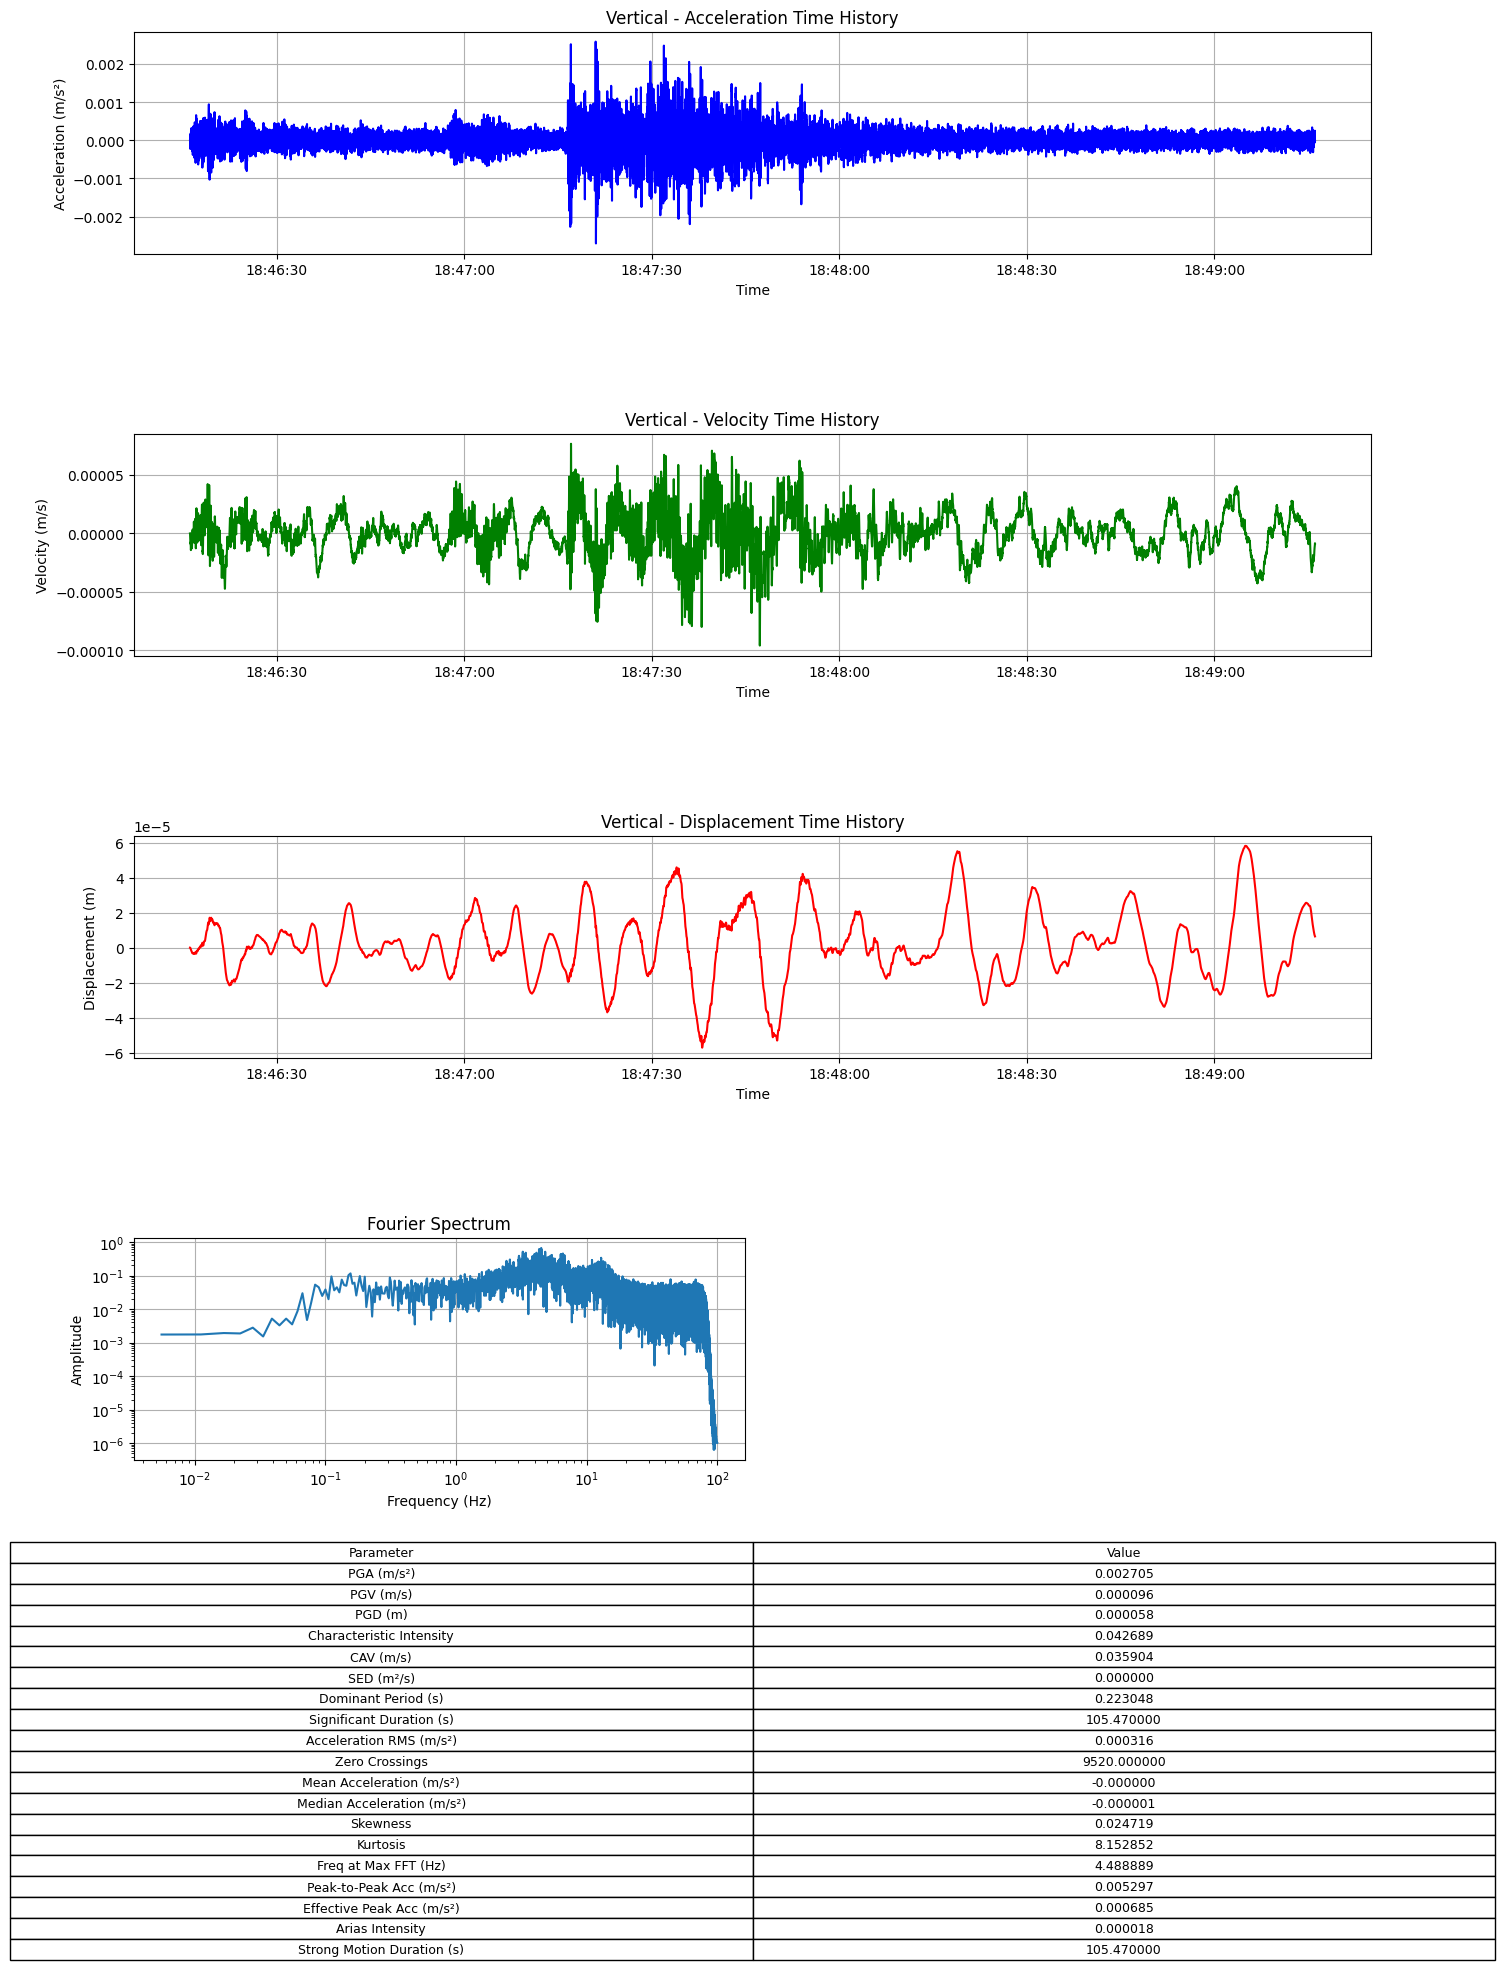

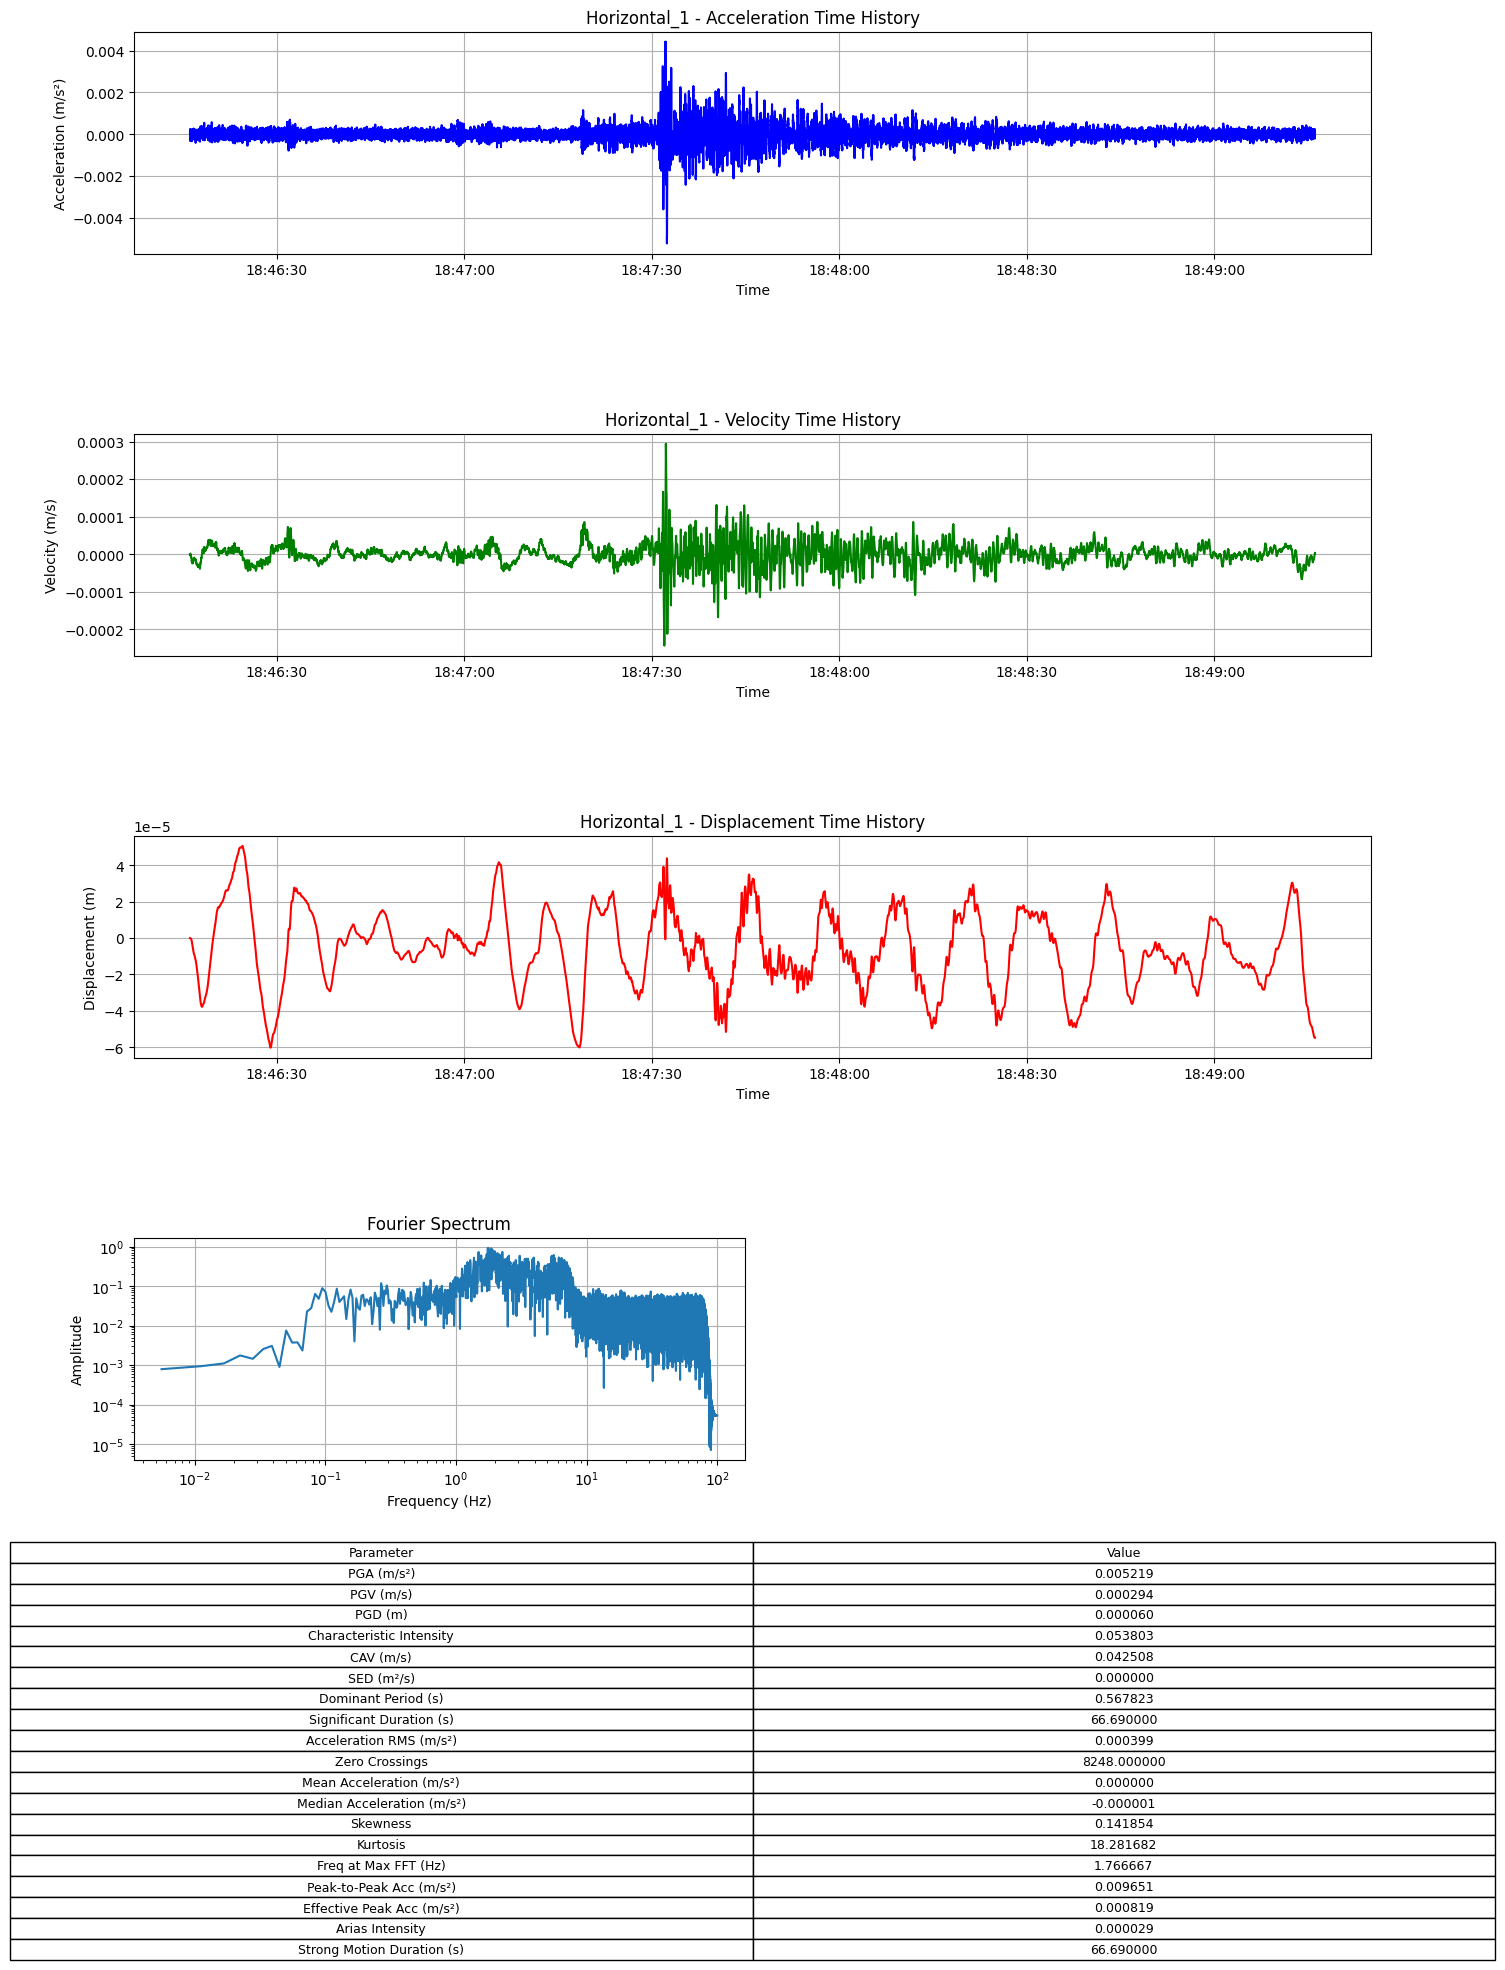

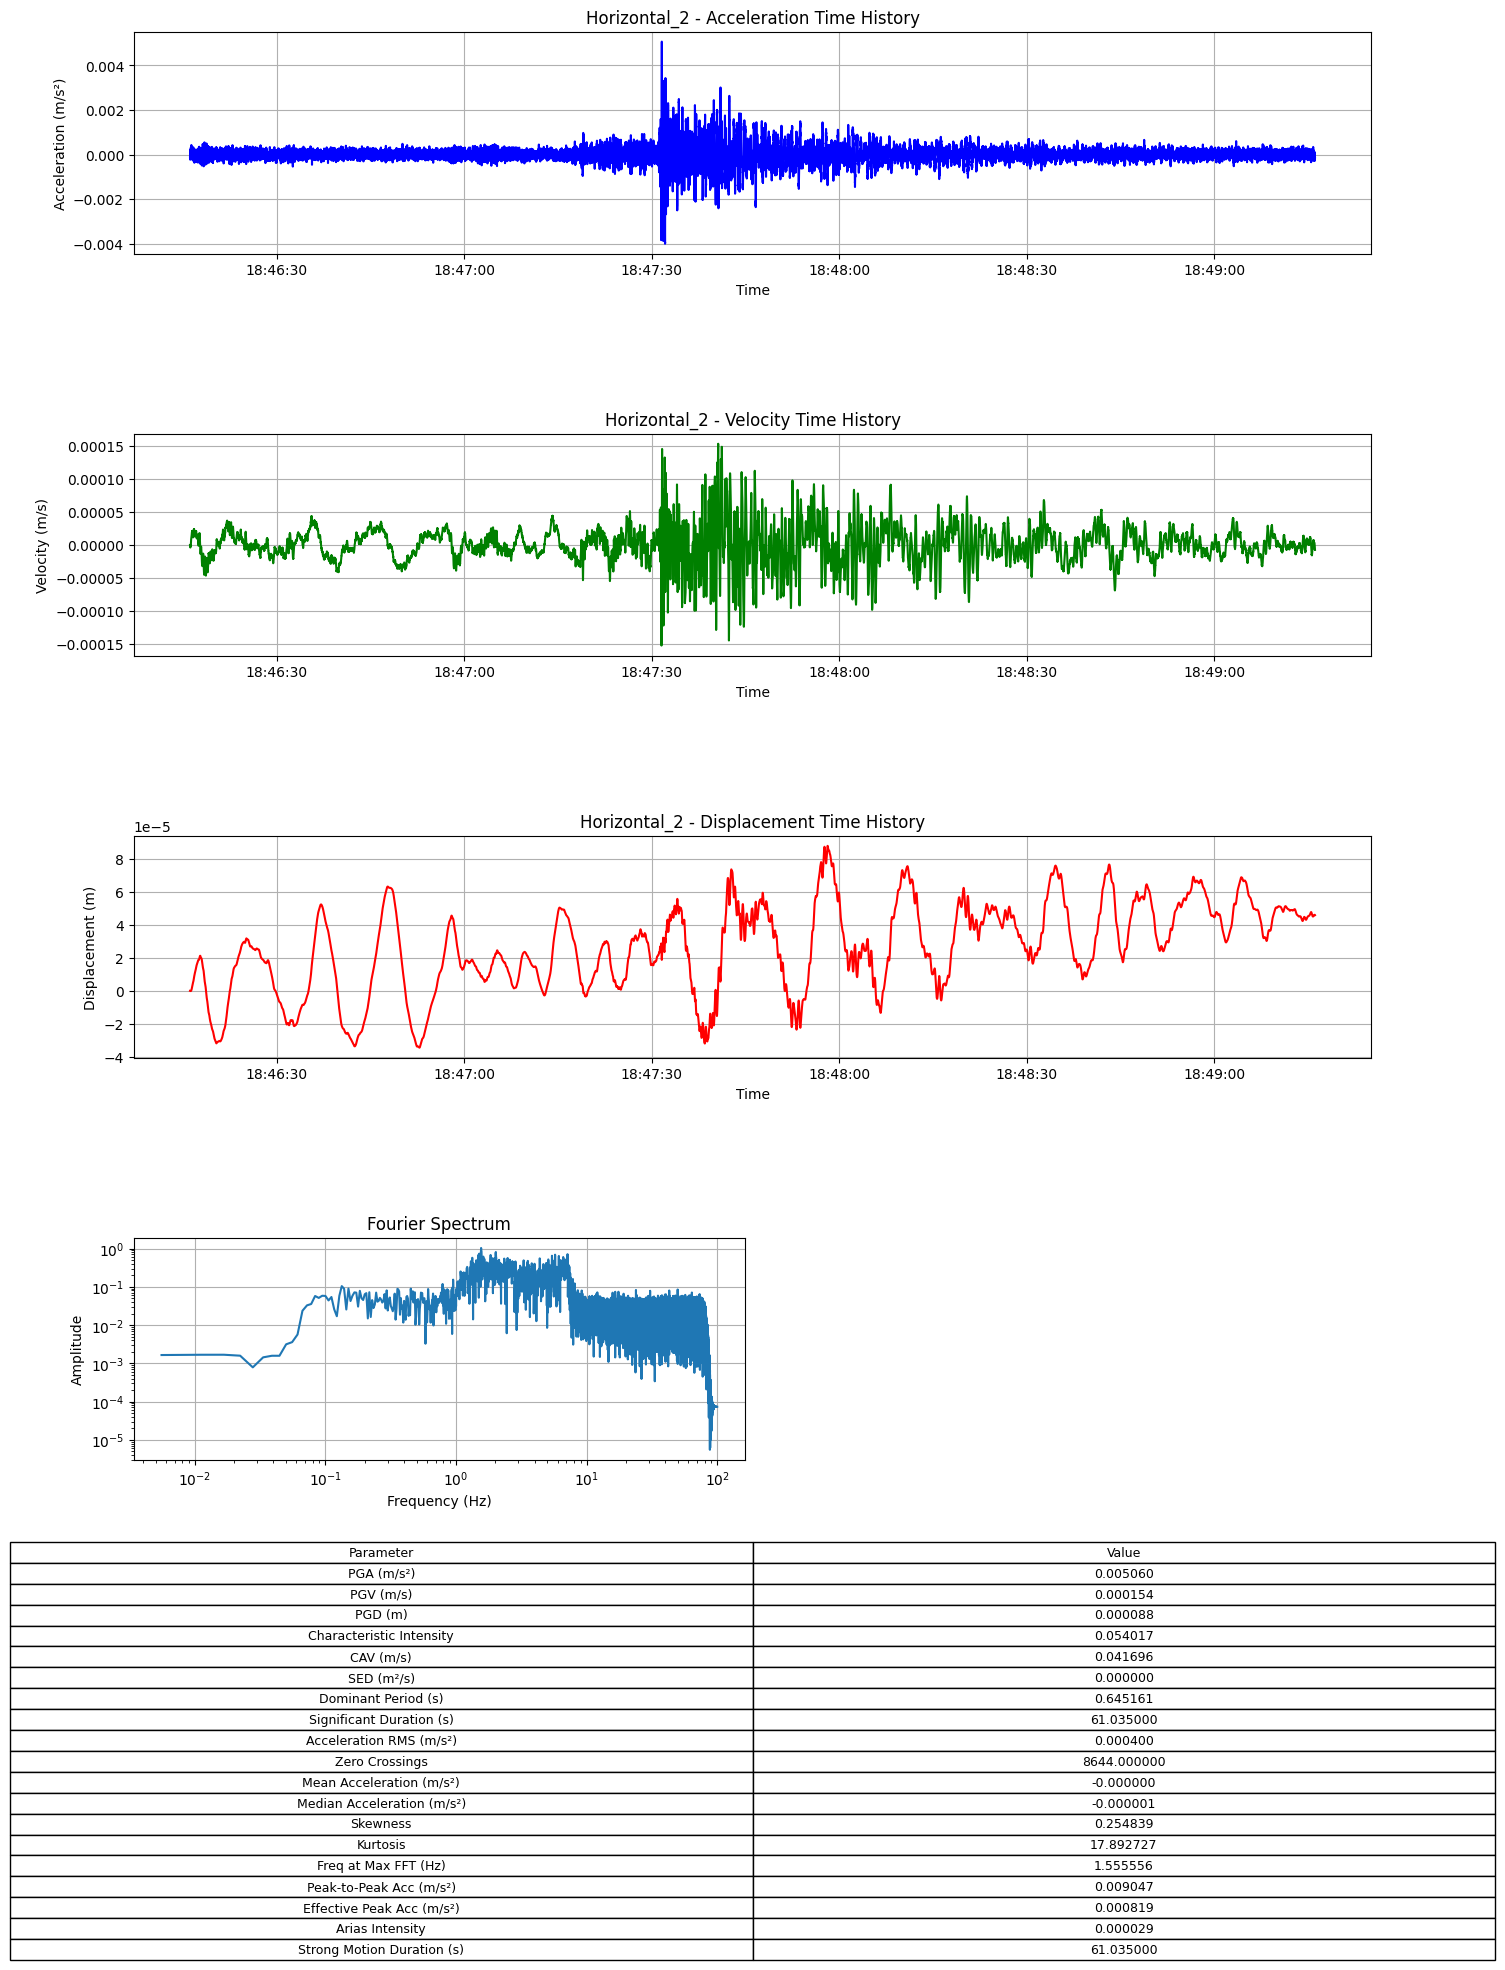

2024-11-17 19:49:55,325 - SeismicAnalyzer - INFO - Analysis completed successfully
2024-11-17 19:49:55,325 - SeismicAnalyzer - INFO - Analysis completed successfully
INFO:SeismicAnalyzer:Analysis completed successfully


In [5]:
import os
import logging
import pandas as pd
import numpy as np
from scipy import integrate
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from matplotlib import gridspec


class SeismicAnalyzer:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.setup_logging()

    def setup_logging(self):
        self.logger = logging.getLogger('SeismicAnalyzer')
        self.logger.setLevel(logging.INFO)
        ch = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        ch.setFormatter(formatter)
        self.logger.addHandler(ch)

    def read_data(self):
        """Read and parse the CSV file"""
        try:
            with open(self.csv_file, 'r') as f:
                lines = f.readlines()

            for i, line in enumerate(lines):
                if line.startswith('Stream'):
                    header_line = i
                    break

            self.data = pd.read_csv(
                self.csv_file,
                skiprows=header_line + 1,
                names=['Station_ID', 'Time', 'Vertical', 'Horizontal_1', 'Horizontal_2']
            )
            self.data = self.data.drop('Station_ID', axis=1)
            self.column_mapping = {
                'Time': 'Time',
                'Vertical': 'Vertical',
                'Horizontal_1': 'Horizontal_1',
                'Horizontal_2': 'Horizontal_2'
            }
            self.data['Time'] = pd.to_datetime(self.data['Time'], format='%Y-%m-%dT%H:%M:%S.%f')
            for component in ['Vertical', 'Horizontal_1', 'Horizontal_2']:
                self.data[component] = pd.to_numeric(self.data[component], errors='coerce')

            self.logger.info("Successfully read CSV file")
        except Exception as e:
            self.logger.error(f"Error reading CSV file: {str(e)}")
            raise

    def calculate_ground_motion_parameters(self, component_data, dt):
        """Calculate ground motion parameters with extended analysis"""
        try:
            acc = component_data.values
            vel = integrate.cumtrapz(acc, dx=dt, initial=0)
            disp = integrate.cumtrapz(vel, dx=dt, initial=0)

            pga = np.abs(acc).max()
            pgv = np.abs(vel).max()
            pgd = np.abs(disp).max()
            arms = np.sqrt(np.mean(acc**2))
            Ic = arms * 1.5 * (dt * len(acc)) * 0.5
            cav = integrate.trapz(np.abs(acc), dx=dt)
            sed = integrate.trapz(vel**2, dx=dt)
            freq = fftfreq(len(acc), dt)
            fft_amp = np.abs(fft(acc))
            dominant_freq = freq[np.argmax(fft_amp[1:])]
            dominant_period = 1 / abs(dominant_freq) if dominant_freq != 0 else 0

            acc_squared = acc**2
            cumulative_energy = np.cumsum(acc_squared) / np.sum(acc_squared)
            t5_index = np.where(cumulative_energy >= 0.05)[0][0]
            t95_index = np.where(cumulative_energy >= 0.95)[0][0]
            significant_duration = (t95_index - t5_index) * dt

            acc_rms = np.sqrt(np.mean(acc**2))

            # Additional Analyses
            zero_crossings = ((acc[:-1] * acc[1:]) < 0).sum()
            mean_acc = np.mean(acc)
            median_acc = np.median(acc)
            skewness = skew(acc)
            kurt = kurtosis(acc)
            freq_at_max_fft = freq[np.argmax(fft_amp)]
            peak_to_peak = np.ptp(acc)
            effective_peak_acc = np.percentile(np.abs(acc), 95)
            arias_intensity = integrate.trapz(acc_squared, dx=dt)
            strong_motion_duration = (np.where(cumulative_energy >= 0.95)[0][0] - np.where(cumulative_energy >= 0.05)[0][0]) * dt

            return {
                'PGA (m/s²)': pga,
                'PGV (m/s)': pgv,
                'PGD (m)': pgd,
                'Characteristic Intensity': Ic,
                'CAV (m/s)': cav,
                'SED (m²/s)': sed,
                'Dominant Period (s)': dominant_period,
                'Significant Duration (s)': significant_duration,
                'Acceleration RMS (m/s²)': acc_rms,
                'Zero Crossings': zero_crossings,
                'Mean Acceleration (m/s²)': mean_acc,
                'Median Acceleration (m/s²)': median_acc,
                'Skewness': skewness,
                'Kurtosis': kurt,
                'Freq at Max FFT (Hz)': freq_at_max_fft,
                'Peak-to-Peak Acc (m/s²)': peak_to_peak,
                'Effective Peak Acc (m/s²)': effective_peak_acc,
                'Arias Intensity': arias_intensity,
                'Strong Motion Duration (s)': strong_motion_duration
            }
        except Exception as e:
            self.logger.error(f"Error calculating parameters: {str(e)}")
            raise

    def plot_component_analysis(self, component_name, time_data, acc_data, parameters):
        """Create and show detailed plots for each component"""
        try:
            time = time_data.values
            dt = (time_data.iloc[1] - time_data.iloc[0]).total_seconds()
            acc = acc_data.values
            vel = integrate.cumtrapz(acc, dx=dt, initial=0)
            disp = integrate.cumtrapz(vel, dx=dt, initial=0)

            fig = plt.figure(figsize=(15, 20))
            gs = gridspec.GridSpec(5, 2, figure=fig)

            ax1 = fig.add_subplot(gs[0, :])
            ax1.plot(time, acc, label='Acceleration', color='blue')
            ax1.set_xlabel('Time')
            ax1.set_ylabel('Acceleration (m/s²)')
            ax1.set_title(f'{component_name} - Acceleration Time History')
            ax1.grid(True)

            ax2 = fig.add_subplot(gs[1, :])
            ax2.plot(time, vel, label='Velocity', color='green')
            ax2.set_xlabel('Time')
            ax2.set_ylabel('Velocity (m/s)')
            ax2.set_title(f'{component_name} - Velocity Time History')
            ax2.grid(True)

            ax3 = fig.add_subplot(gs[2, :])
            ax3.plot(time, disp, label='Displacement', color='red')
            ax3.set_xlabel('Time')
            ax3.set_ylabel('Displacement (m)')
            ax3.set_title(f'{component_name} - Displacement Time History')
            ax3.grid(True)

            freq = fftfreq(len(acc), dt)
            fft_amp = np.abs(fft(acc))
            mask = freq > 0
            ax4 = fig.add_subplot(gs[3, 0])
            ax4.loglog(freq[mask], fft_amp[mask])
            ax4.set_title('Fourier Spectrum')
            ax4.set_xlabel('Frequency (Hz)')
            ax4.set_ylabel('Amplitude')
            ax4.grid(True)

            ax5 = fig.add_subplot(gs[4, :])
            ax5.axis('off')
            table_data = [[k, f"{v:.6f}"] for k, v in parameters.items()]
            table = ax5.table(cellText=table_data, colLabels=['Parameter', 'Value'], cellLoc='center', loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(9)
            table.scale(1.2, 1.5)

            plt.tight_layout()
            plt.show()
        except Exception as e:
            self.logger.error(f"Error creating plots for {component_name}: {str(e)}")
            raise

    def run_analysis(self):
        """Run the complete analysis workflow"""
        try:
            self.read_data()
            time_data = self.data[self.column_mapping['Time']]
            dt = (time_data.iloc[1] - time_data.iloc[0]).total_seconds()

            results = {}
            for component_key, column_name in self.column_mapping.items():
                if component_key != 'Time':
                    params = self.calculate_ground_motion_parameters(self.data[column_name], dt)
                    results[component_key] = params
                    self.plot_component_analysis(component_key, time_data, self.data[column_name], params)

            self.logger.info("Analysis completed successfully")
            return results
        except Exception as e:
            self.logger.error(f"Error in analysis workflow: {str(e)}")
            raise


# Example usage (replace 'your_file.csv' with your actual CSV file path)
analyzer = SeismicAnalyzer(csv_file='/content/btp_data.csv')
analysis_results = analyzer.run_analysis()

**Time Series Analaysis**

**Correlation Analysis**

**Clustering Analysis**

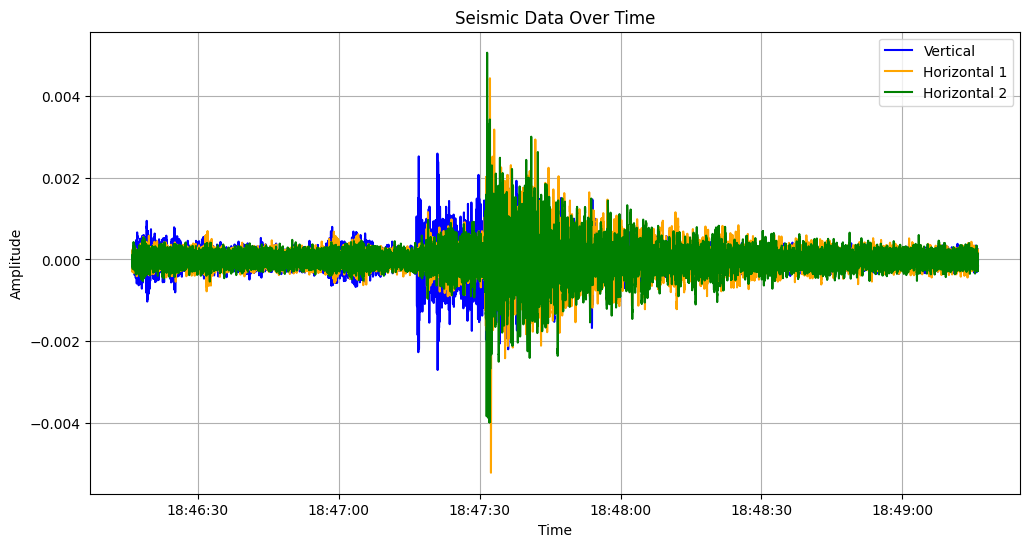

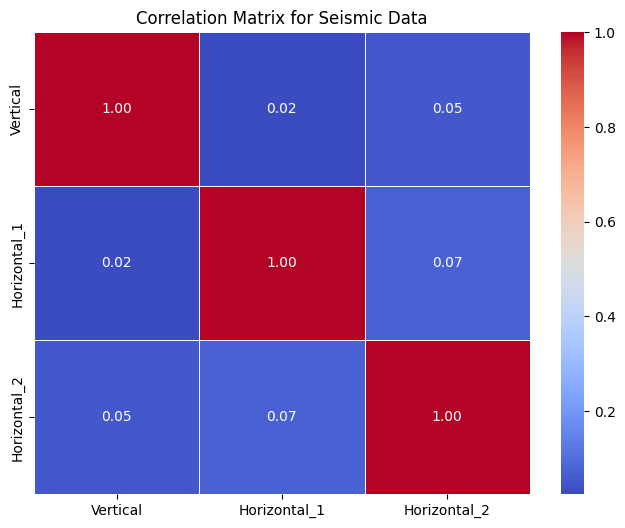

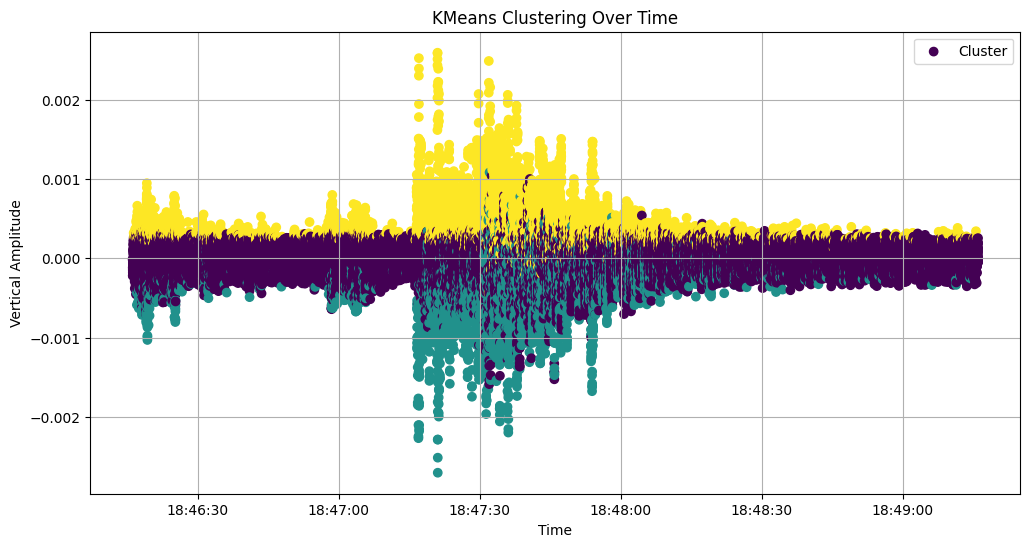

Silhouette Score for KMeans clustering: 0.402


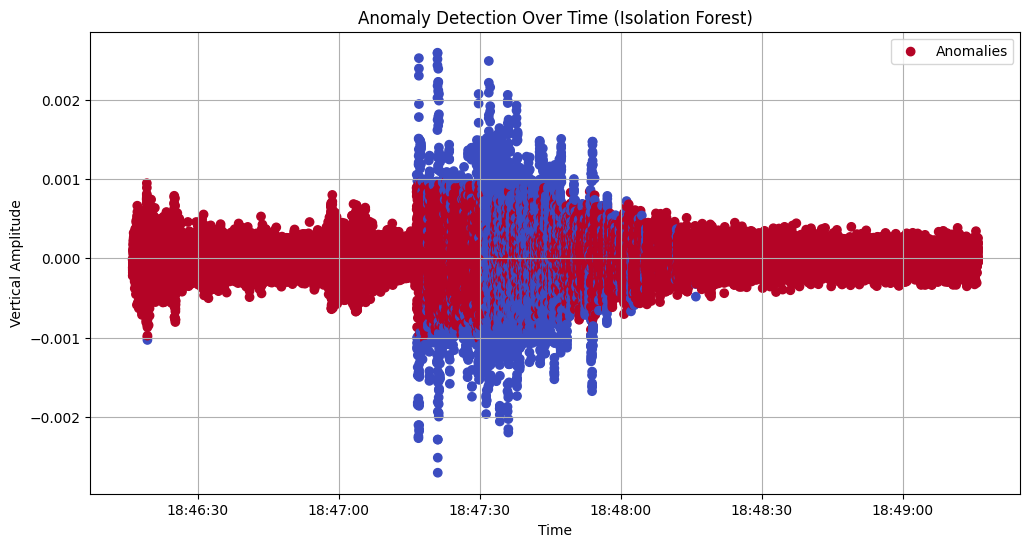

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest

class SeismicDataAnalyzer:
    def __init__(self, csv_file, logger):
        self.csv_file = csv_file
        self.logger = logger
        self.data = None
        self.column_mapping = None

    def read_data(self):
        """Read and parse the CSV file"""
        try:
            with open(self.csv_file, 'r') as f:
                lines = f.readlines()

            for i, line in enumerate(lines):
                if line.startswith('Stream'):
                    header_line = i
                    break

            # Read CSV with proper header line and column names
            self.data = pd.read_csv(
                self.csv_file,
                skiprows=header_line + 1,
                names=['Station_ID', 'Time', 'Vertical', 'Horizontal_1', 'Horizontal_2']
            )
            self.data = self.data.drop('Station_ID', axis=1)

            # Mapping columns for consistency
            self.column_mapping = {
                'Time': 'Time',
                'Vertical': 'Vertical',
                'Horizontal_1': 'Horizontal_1',
                'Horizontal_2': 'Horizontal_2'
            }
            # Convert 'Time' to datetime
            self.data['Time'] = pd.to_datetime(self.data['Time'], format='%Y-%m-%dT%H:%M:%S.%f')

            # Convert components to numeric, coercing errors
            for component in ['Vertical', 'Horizontal_1', 'Horizontal_2']:
                self.data[component] = pd.to_numeric(self.data[component], errors='coerce')

            # Drop rows with missing values
            self.data.dropna(inplace=True)

            self.logger.info("Successfully read and cleaned CSV file")
        except Exception as e:
            self.logger.error(f"Error reading CSV file: {str(e)}")
            raise

    def time_series_analysis(self):
        """Perform time series analysis (plotting the data over time)"""
        plt.figure(figsize=(12, 6))
        plt.plot(self.data['Time'], self.data['Vertical'], label='Vertical', color='blue')
        plt.plot(self.data['Time'], self.data['Horizontal_1'], label='Horizontal 1', color='orange')
        plt.plot(self.data['Time'], self.data['Horizontal_2'], label='Horizontal 2', color='green')
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.title("Seismic Data Over Time")
        plt.legend()
        plt.grid()
        plt.show()

    def correlation_analysis(self):
        """Perform correlation analysis and plot heatmap"""
        # Correlation matrix
        corr_matrix = self.data[['Vertical', 'Horizontal_1', 'Horizontal_2']].corr()

        # Plotting heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title("Correlation Matrix for Seismic Data")
        plt.show()

    def clustering_analysis(self):
        """Perform clustering using KMeans and anomaly detection with Isolation Forest"""
        # Standardize data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(self.data[['Vertical', 'Horizontal_1', 'Horizontal_2']])

        # KMeans Clustering
        kmeans = KMeans(n_clusters=3, random_state=42)
        self.data['Cluster'] = kmeans.fit_predict(scaled_data)

        # Plot KMeans Clusters
        plt.figure(figsize=(12, 6))
        plt.scatter(self.data['Time'], self.data['Vertical'], c=self.data['Cluster'], cmap='viridis', label='Cluster')
        plt.xlabel("Time")
        plt.ylabel("Vertical Amplitude")
        plt.title("KMeans Clustering Over Time")
        plt.legend()
        plt.grid()
        plt.show()

        # Calculate Silhouette Score for clustering quality
        silhouette_avg = silhouette_score(scaled_data, self.data['Cluster'])
        print(f"Silhouette Score for KMeans clustering: {silhouette_avg:.3f}")

        # Anomaly Detection using Isolation Forest
        isolation_forest = IsolationForest(contamination=0.1, random_state=42)
        self.data['Anomaly'] = isolation_forest.fit_predict(scaled_data)

        # Plot Anomalies
        plt.figure(figsize=(12, 6))
        plt.scatter(self.data['Time'], self.data['Vertical'], c=self.data['Anomaly'], cmap='coolwarm', label='Anomalies')
        plt.xlabel("Time")
        plt.ylabel("Vertical Amplitude")
        plt.title("Anomaly Detection Over Time (Isolation Forest)")
        plt.legend()
        plt.grid()
        plt.show()


# Example usage
import logging

# Initialize logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Create SeismicDataAnalyzer instance
analyzer = SeismicDataAnalyzer('/content/btp_data.csv', logger)

# Read data
analyzer.read_data()

# Perform Time Series Analysis
analyzer.time_series_analysis()

# Perform Correlation Analysis
analyzer.correlation_analysis()

# Perform Clustering and Anomaly Detection
analyzer.clustering_analysis()